In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


2025-04-20 22:28:41.689736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:28:41.692980: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:28:41.702119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745188121.716735   18101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745188121.721134   18101 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745188121.733533   18101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")



def run_backtest(df, freq='h',name=""):

  
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  
  
  df['strategy_return'] = df['signal'] * df['return_forward']

  
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  
  
  
  
  
  
  
  

  
  
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [4]:
merged_df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [5]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [6]:
merged_df.drop(columns=['target'], inplace=True)

In [ ]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")



price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-01-01 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001385,143.55,210.51,...,1,1,1,0,1,0,0.071577,0.097778,0.003539,0.010173
2024-01-01 01:00:00,1.0,-0.300000,0.000000,0.000000,0.000000,0.200000,0.0,-0.000729,151.35,210.81,...,1,0,1,0,1,0,0.047718,0.089956,0.002359,0.009359
2024-01-01 02:00:00,3.0,-0.233333,0.000000,-0.066667,0.000000,0.333333,0.0,-0.005929,120.60,219.66,...,1,0,1,1,1,0,0.249945,0.135111,0.028840,0.015154
2024-01-01 03:00:00,4.0,0.250000,0.000000,-0.500000,0.000000,-0.175000,0.0,0.000095,43.45,223.39,...,1,0,1,1,1,0,0.166630,0.124302,0.019226,0.013942
2024-01-01 04:00:00,2.0,0.000000,0.000000,-0.450000,0.000000,0.150000,0.0,0.005017,-37.10,221.12,...,1,0,1,1,1,1,0.111087,0.114358,0.012818,0.012827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


In [8]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [10]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    
    returns = y_pred - y_true
    
    
    positive_weight = 0.5
    negative_weight = 1.5
    
    
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs, outputs)


input_shape = (X_train.shape[1], X_train.shape[2])
model = build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=2,
    ff_dim=64,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.1,
)


model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test)


predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions


Epoch 1/100


2025-04-20 22:28:43.756059: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0118 - val_loss: 3.8283e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0035 - val_loss: 8.7781e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0026 - val_loss: 2.9655e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0022 - val_loss: 3.3604e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0020 - val_loss: 3.0655e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0018 - val_loss: 4.0800e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0017 - val_loss: 2.8289e-04
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0016 - val_loss: 2.8470e-04
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0015 - val_loss: 2.6734e-04
Epoch 10/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0015 - val_loss: 3.3331e-04
Epoch 11/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0014 - val_loss: 2.6045e-04
Epoch 12/

array([[-1.3002048e-05],
       [-4.3825644e-06],
       [-1.2174016e-04],
       ...,
       [ 6.7741152e-05],
       [ 8.5982319e-06],
       [-8.2959843e-05]], dtype=float32)

In [ ]:
model.save('transformer_mse.keras')  


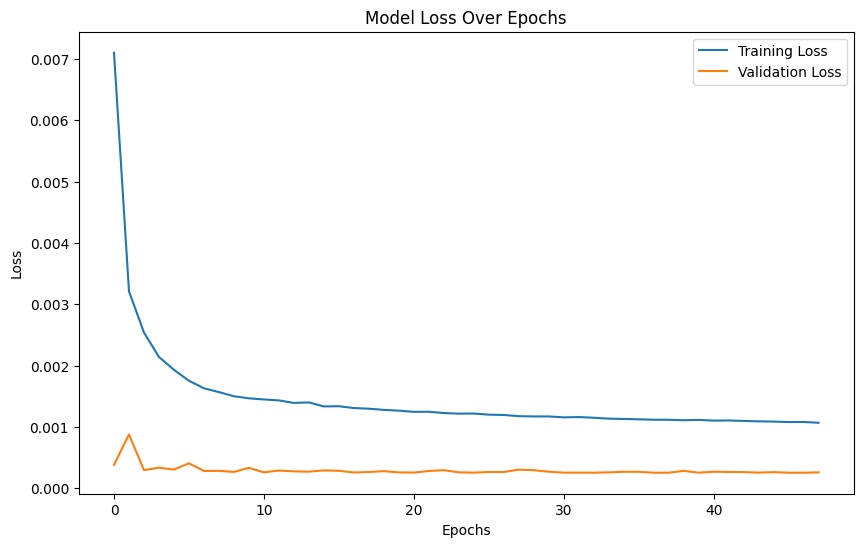

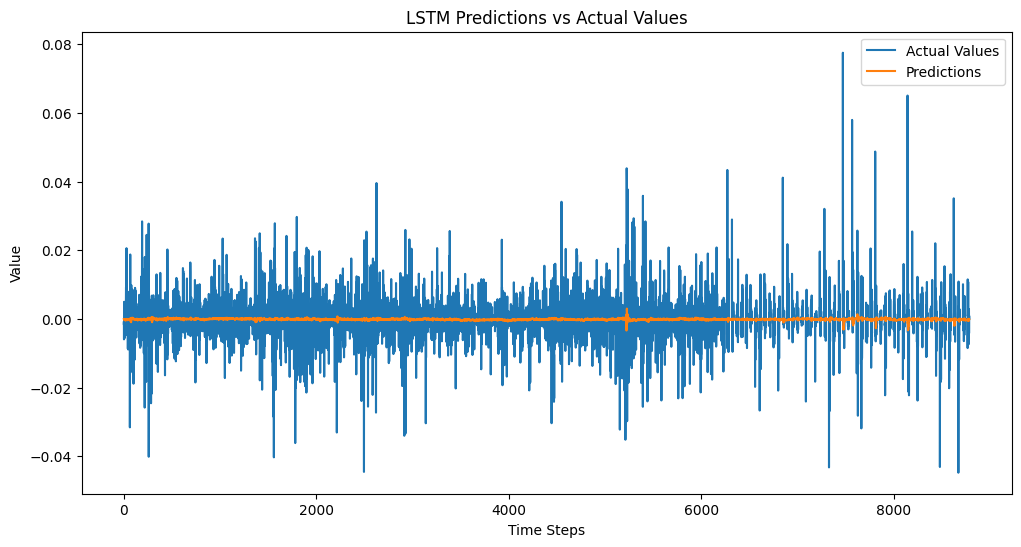

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('transformer_mse.keras')  
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted']
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,-0.000013,0,-1
2024-01-01 01:00:00,-0.000729,-0.000004,0,0
2024-01-01 02:00:00,-0.005929,-0.000122,-1,-1
2024-01-01 03:00:00,0.000095,-0.000217,-1,0
2024-01-01 04:00:00,0.005017,-0.000154,-1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.000090,0,-1
2024-12-31 20:00:00,0.002858,-0.000061,0,1
2024-12-31 21:00:00,-0.004142,0.000068,0,-1
2024-12-31 22:00:00,0.000933,0.000009,0,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3344
Precision (Weighted): 0.3476
Recall (Weighted): 0.3344
F1 Score (Weighted): 0.3174
\nMetrics per class:
  Class -1:
    Precision: 0.2957
    Recall:    0.4909
    F1 Score:  0.3691
  Class 0:
    Precision: 0.3767
    Recall:    0.3790
    F1 Score:  0.3779
  Class 1:
    Precision: 0.3623
    Recall:    0.1384
    F1 Score:  0.2003


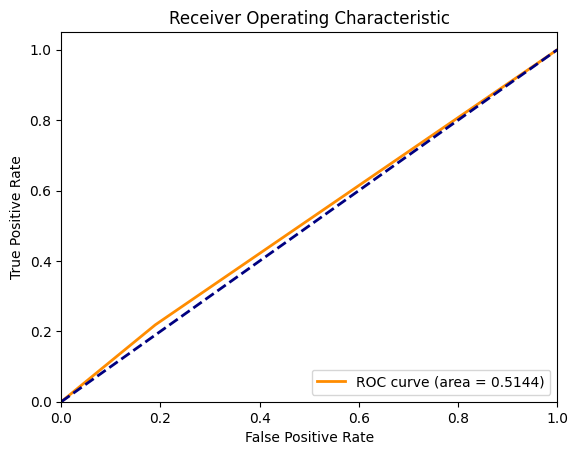

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: -42.28%
Overall Annual Sharpe Ratio: -1.0987
Maximum Drawdown: -60.45 %
Alpha: -0.1752
Beta: -0.2888

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.422838    0.419979    -0.288825     -0.192583      -1.098737


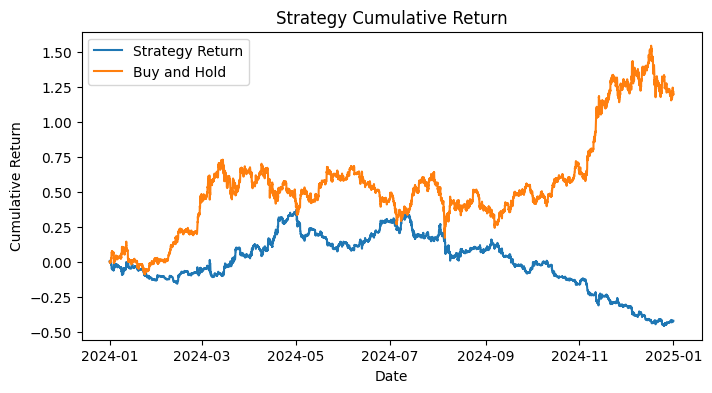

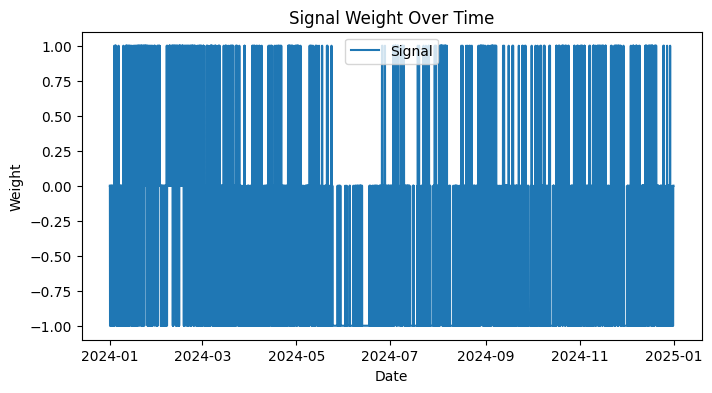

In [21]:
run_backtest(stat_signal_result_df, name ="transformer_MSE_Hybrid")

In [22]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [24]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

@register_keras_serializable(package="Custom", name="directional_penalty_loss")
def directional_penalty_loss(y_true, y_pred):
    """
    Custom loss function that penalizes incorrect directional predictions more heavily.
    It combines Mean Squared Error (MSE) with an additional penalty if the predicted
    direction (sign) is different from the true direction.

    Args:
        y_true: True target values (actual returns).
        y_pred: Predicted values (predicted returns).

    Returns:
        A scalar tensor representing the calculated loss.
    """
    
    mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)

    
    
    wrong_direction = K.not_equal(tf.sign(y_true), tf.sign(y_pred))
    
    
    directional_penalty_mask = tf.cast(wrong_direction, K.floatx())

    
    
    penalty_magnitude = 0.1 

    
    directional_penalty = K.mean(directional_penalty_mask * penalty_magnitude, axis=-1)

    
    total_loss = mse_loss + directional_penalty
    
    return total_loss

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs, outputs)


input_shape = (X_train.shape[1], X_train.shape[2])
model = build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=2,
    ff_dim=64,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.1,
)


model.compile(optimizer=Adam(learning_rate=1e-4), loss=directional_penalty_loss)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test)


predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions


Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0988 - val_loss: 8.1987e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0054 - val_loss: 3.7094e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0038 - val_loss: 4.1934e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0031 - val_loss: 4.9188e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0027 - val_loss: 3.1954e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0024 - val_loss: 2.9853e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0021 - val_loss: 3.6385e-04
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0019 - val_loss: 2.9305e-04
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0019 - val_loss: 2.9231e-04
Epoch 10/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0017 - val_loss: 3.4357e-04
Epoch 11/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0016 - val_loss: 3.0598e-

array([[ 0.00044237],
       [ 0.00039398],
       [ 0.00041883],
       ...,
       [-0.00015458],
       [ 0.00012388],
       [ 0.00031831]], dtype=float32)

In [ ]:
model.save('transformer_dl.keras')  


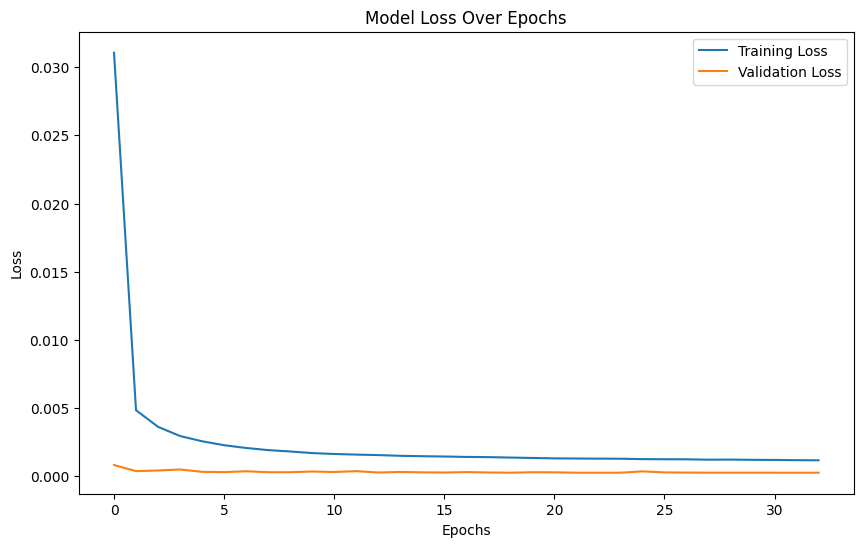

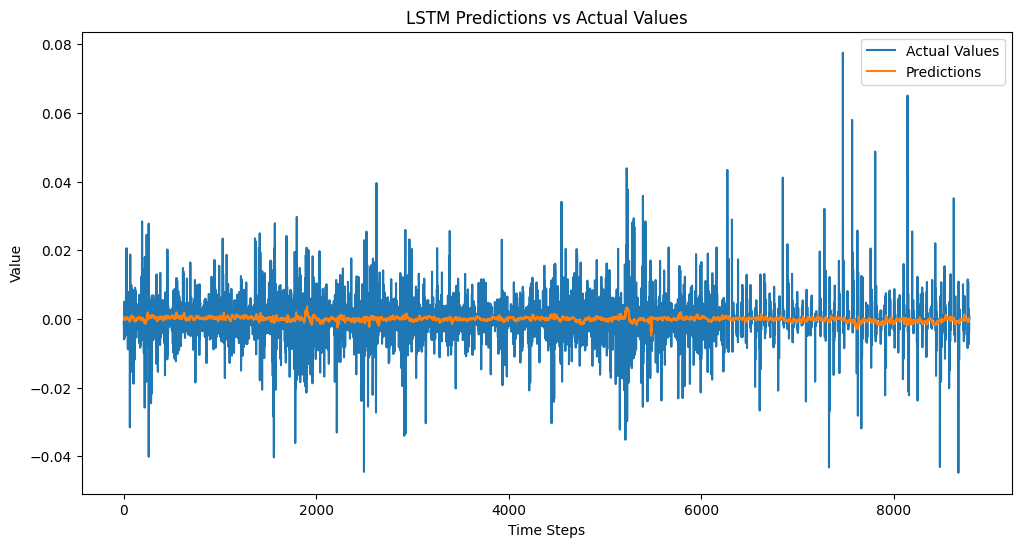

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('transformer_dl.keras')  
predictions = model.predict(X_test, )
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.00001 else (-1 if x < -0.00001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.000442,1,-1
2024-01-01 01:00:00,-0.000729,0.000394,1,0
2024-01-01 02:00:00,-0.005929,0.000419,1,-1
2024-01-01 03:00:00,0.000095,0.000369,1,0
2024-01-01 04:00:00,0.005017,0.000281,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.000437,-1,-1
2024-12-31 20:00:00,0.002858,-0.000086,-1,1
2024-12-31 21:00:00,-0.004142,-0.000155,-1,-1
2024-12-31 22:00:00,0.000933,0.000124,1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3235
Precision (Weighted): 0.3322
Recall (Weighted): 0.3235
F1 Score (Weighted): 0.2577
\nMetrics per class:
  Class -1:
    Precision: 0.2917
    Recall:    0.4502
    F1 Score:  0.3540
  Class 0:
    Precision: 0.3481
    Recall:    0.0144
    F1 Score:  0.0276
  Class 1:
    Precision: 0.3514
    Recall:    0.5601
    F1 Score:  0.4318


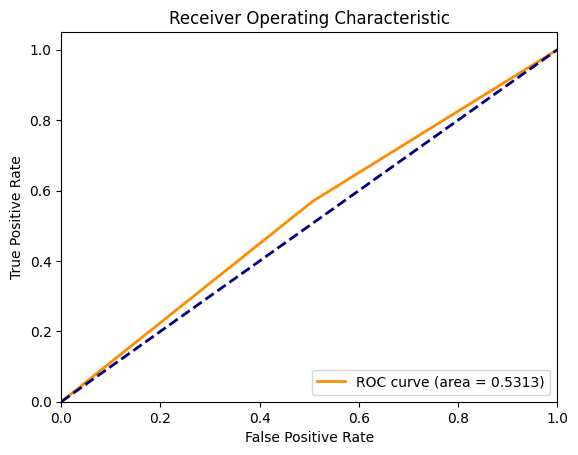

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 40.56%
Overall Annual Sharpe Ratio: 0.9116
Maximum Drawdown: -40.23 %
Alpha: 0.474
Beta: 0.0966

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.405573    0.524298     0.096624      0.388019       0.911628


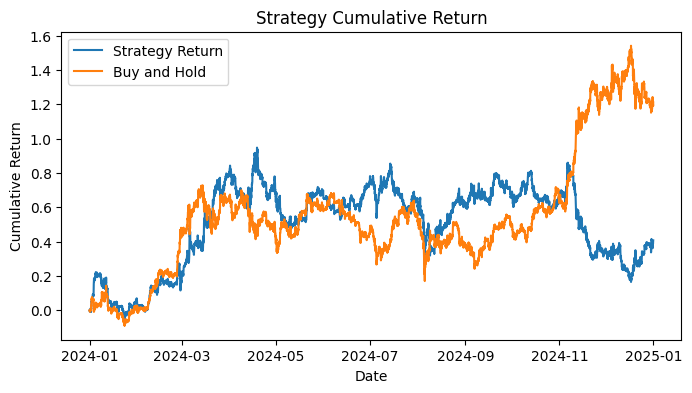

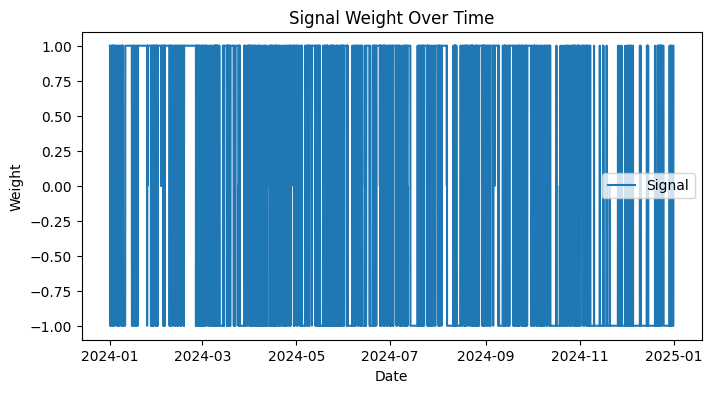

In [32]:
run_backtest(stat_signal_result_df, name ="transformer_Directional_Hybrid")

In [33]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [35]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    
    returns = y_pred - y_true
    
    
    positive_weight = 0.5
    negative_weight = 1.5
    
    
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs, outputs)


input_shape = (X_train.shape[1], X_train.shape[2])
model = build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=2,
    ff_dim=64,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.1,
)


model.compile(optimizer=Adam(learning_rate=1e-4), loss=weighted_loss)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test)


predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions


Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0574 - val_loss: 5.6829e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0049 - val_loss: 5.1207e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0033 - val_loss: 6.0263e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0026 - val_loss: 3.9351e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0022 - val_loss: 4.8474e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0019 - val_loss: 5.9261e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0018 - val_loss: 3.5699e-04
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0017 - val_loss: 6.7440e-04
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0016 - val_loss: 6.1434e-04
Epoch 10/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0015 - val_loss: 2.9517e-04
Epoch 11/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0014 - val_loss: 5.3027e-

array([[ 0.00151829],
       [ 0.00148201],
       [ 0.00145437],
       ...,
       [-0.00036832],
       [ 0.00083389],
       [ 0.00015078]], dtype=float32)

In [ ]:
model.save('transformer_wl.keras')  


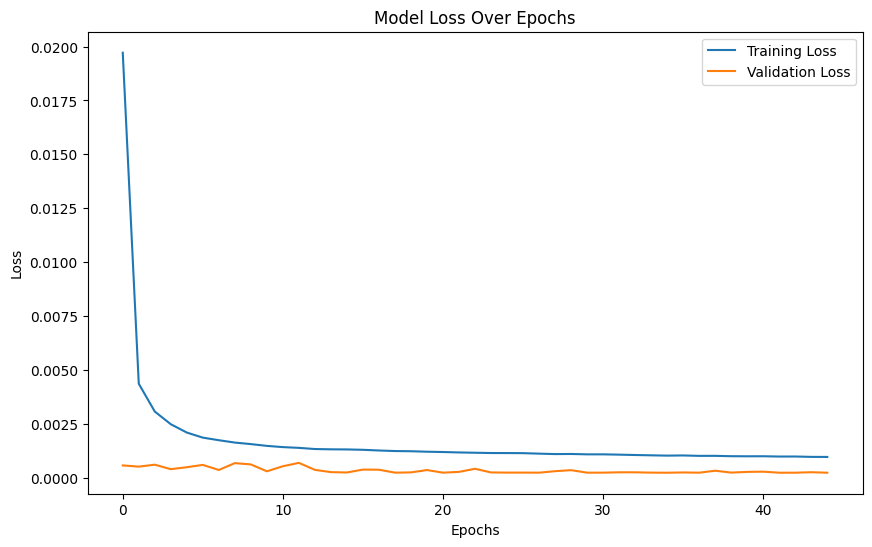

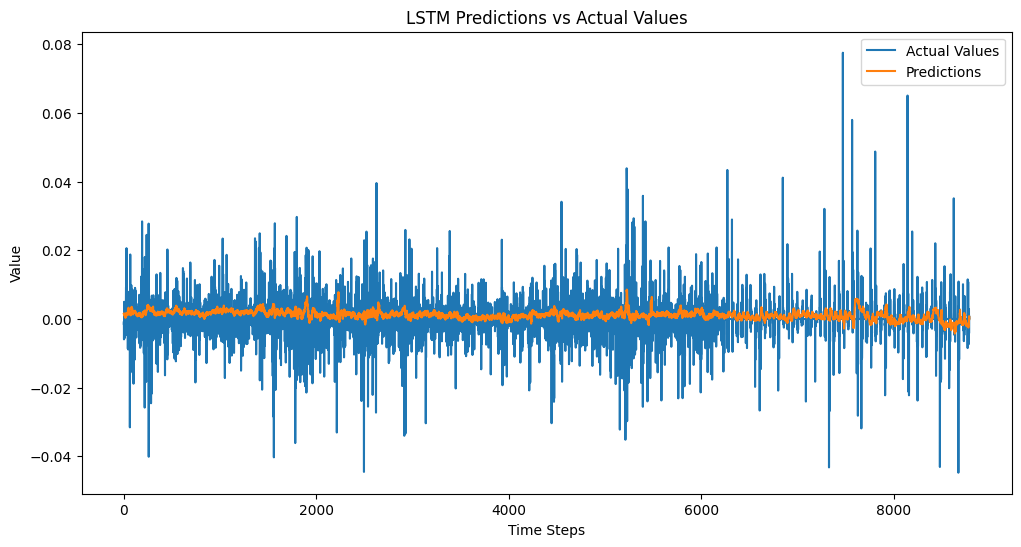

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('transformer_wl.keras')  
predictions = model.predict(X_test, )
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.001 else (-1 if x < -0.001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.001518,1,-1
2024-01-01 01:00:00,-0.000729,0.001482,1,0
2024-01-01 02:00:00,-0.005929,0.001454,1,-1
2024-01-01 03:00:00,0.000095,0.001516,1,0
2024-01-01 04:00:00,0.005017,0.001587,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.000855,0,-1
2024-12-31 20:00:00,0.002858,0.000073,0,1
2024-12-31 21:00:00,-0.004142,-0.000368,0,-1
2024-12-31 22:00:00,0.000933,0.000834,0,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3851
Precision (Weighted): 0.3300
Recall (Weighted): 0.3851
F1 Score (Weighted): 0.3294
\nMetrics per class:
  Class -1:
    Precision: 0.1523
    Recall:    0.0200
    F1 Score:  0.0354
  Class 0:
    Precision: 0.4472
    Recall:    0.4563
    F1 Score:  0.4517
  Class 1:
    Precision: 0.3604
    Recall:    0.6415
    F1 Score:  0.4615


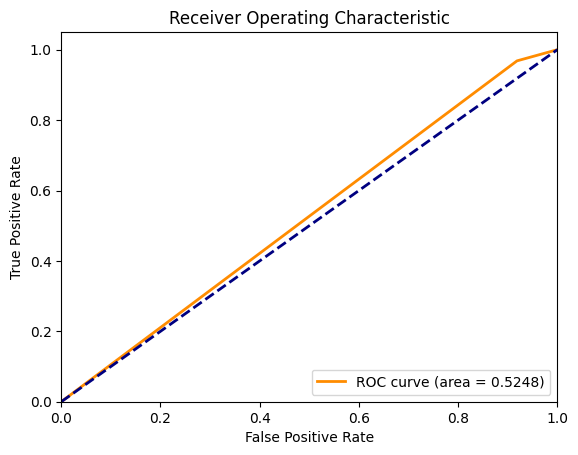

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 35.44%
Overall Annual Sharpe Ratio: 0.9064
Maximum Drawdown: -28.24 %
Alpha: -0.1602
Beta: 0.6189

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.354405    0.443027      0.61889     -0.174563       0.906388


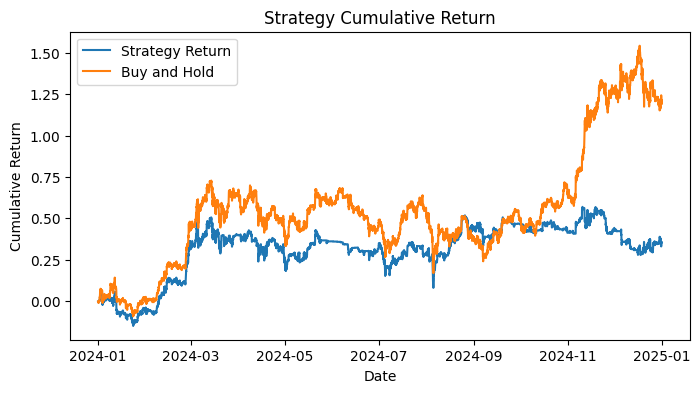

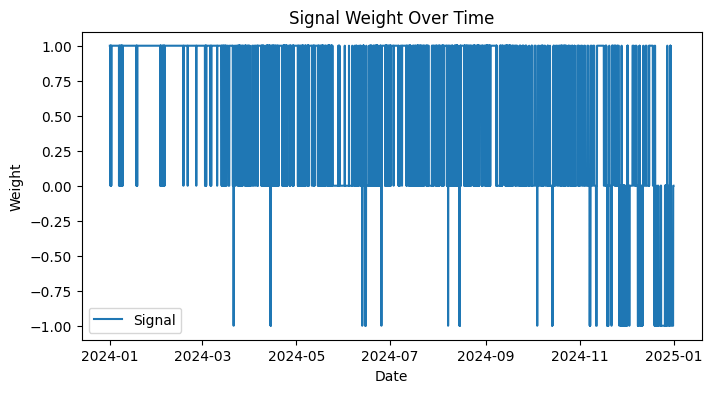

In [43]:
run_backtest(stat_signal_result_df, name ="LSTM_WL_Hybrid")